[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YichenShen0103/CUMCM-25C/blob/main/problem2.ipynb)

In [3]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr, spearmanr
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from statsmodels.stats.multitest import multipletests  # for p-value correction
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
# read in data
url = 'https://raw.githubusercontent.com/YichenShen0103/CUMCM-25C/main/data/data.xlsx'
data = pd.read_excel(url, sheet_name=0)
data.dropna(subset=["检测孕周", "GC含量", "孕妇BMI", "Y染色体浓度"], inplace=True)
data

,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,Y染色体浓度,X染色体浓度,13号染色体的GC含量,18号染色体的GC含量,21号染色体的GC含量,被过滤掉读段数的比例,染色体的非整倍体,怀孕次数,生产次数,胎儿是否健康
0,1,A001,31,160.0,72.00,2023-02-01 00:00:00,自然受孕,20230429,1,11w+6,...,0.025936,0.038061,0.377069,0.389803,0.399399,0.027484,NaN,1,0,是
1,2,A001,31,160.0,73.00,2023-02-01 00:00:00,自然受孕,20230531,2,15w+6,...,0.034887,0.059572,0.371542,0.384771,0.391706,0.019617,NaN,1,0,是
2,3,A001,31,160.0,73.00,2023-02-01 00:00:00,自然受孕,20230625,3,20w+1,...,0.066171,0.075995,0.377449,0.390582,0.399480,0.022312,NaN,1,0,是
3,4,A001,31,160.0,74.00,2023-02-01 00:00:00,自然受孕,20230716,4,22w+6,...,0.061192,0.052305,0.375613,0.389251,0.397212,0.023280,NaN,1,0,是
4,5,A002,32,149.0,74.00,2023-11-09 00:00:00,自然受孕,20240219,1,13w+6,...,0.059230,0.059708,0.380260,0.393618,0.404868,0.024212,NaN,2,1,否
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,1078,A266,30,159.0,83.35,2022-12-29,自然受孕,2023-05-02 00:00:00,4,17w+5,...,0.099052,0.056686,0.376861,0.389914,0.397090,0.017951,T18,1,0,是
1078,1079,A267,28,155.0,73.76,2023-02-25,自然受孕,2023-05-17 00:00:00,1,11w+4,...,0.098706,0.023663,0.377597,0.387901,0.404293,0.022549,T21,1,0,是
1079,1080,A267,28,155.0,74.06,2023-02-25,自然受孕,2023-05-24 00:00:00,2,12w+4,...,0.102088,0.080264,0.379041,0.391748,0.400433,0.021330,NaN,1,0,是
1080,1081,A267,28,155.0,74.74,2023-02-25,自然受孕,2023-05-31 00:00:00,3,13w+4,...,0.109855,0.074050,0.379107,0.388544,0.401030,0.022013,NaN,1,0,是


(74, 4)
57


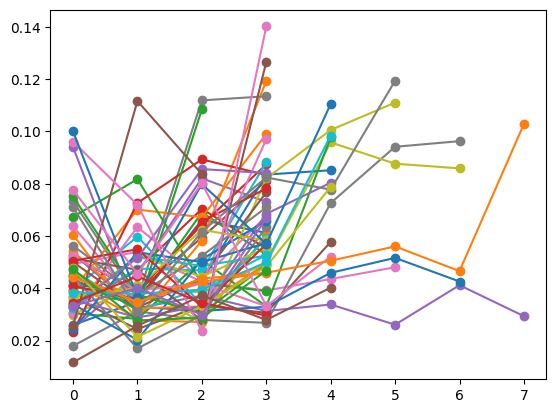

In [5]:
data0 = data.groupby("孕妇代码", as_index=False)["Y染色体浓度"].agg(
    list_values=list, 
    min_value="min", 
    max_value="max"
)
data0 = data0[(data0["min_value"] < 0.04) & (data0["max_value"] > 0.04)]
print(data0.shape)

def is_non_decreasing(lst):
    return all(x <= y for x, y in zip(lst, lst[1:]))

count = 0
for i in data0.index:
    if is_non_decreasing(data0.loc[i, "list_values"]) == False:
        plt.plot(data0.loc[i, "list_values"], marker='o')
        count += 1

print(count)
plt.show()



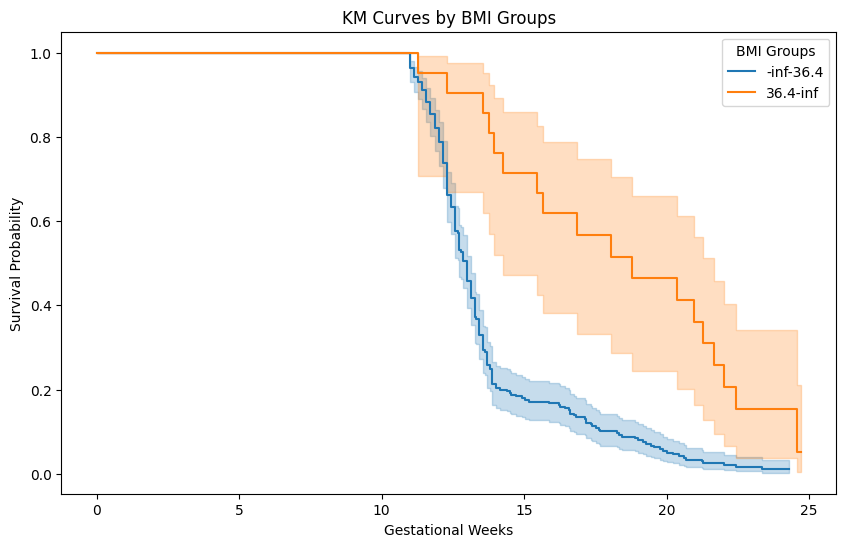

Optimal BMI Cut Points: [36.4]
Cutpoints with Measurement Error: [36.4]
Optimal NIPT Times (weeks):
  -inf-36.4  -> 20.2
  36.4-inf   -> nan
NIPT Times with Measurement Error (weeks):
  -inf-36.4  -> 20.1
  36.4-inf   -> nan


In [6]:


def compute_event_time(df, threshold=0.04):
    results = []
    for mid, sub in df.groupby("mother_id"):
        sub = sub.sort_values("gestational_weeks")
        bmis = sub["bmi"].values
        times = sub["gestational_weeks"].values
        y_concs = sub["y_concentration"].values
        event_time = None
        event_occurred = 0
        for i in range(1, len(y_concs)):
            if y_concs[i - 1] < threshold and y_concs[i] >= threshold:
                # 线性插值计算事件时间
                t1, t2 = times[i - 1], times[i]
                y1, y2 = y_concs[i - 1], y_concs[i]
                event_time = t1 + (threshold - y1) * (t2 - t1) / (y2 - y1)
                event_occurred = 1
                break
        if event_time is None:
            if np.any(y_concs >= threshold):
                event_time = times[np.argmax(y_concs >= threshold)]
                event_occurred = 1
            else:
                event_time = times[-1]
                event_occurred = 0
        # results.append((mid, event_time, event_occurred, bmis))
        event_bmi = sub["bmi"].values[
            np.searchsorted(times, event_time, side="right") - 1
        ]
        results.append((mid, event_time, event_occurred, event_bmi))
    return pd.DataFrame(results, columns=["mother_id", "time", "event", "bmi"])


def find_best_cut(data, min_size=20, alpha=0.05):
    sorted_bmi = np.sort(data["bmi"].unique())
    best_cut = None
    best_p = 1.0
    best_stat = -np.inf

    for cut in sorted_bmi[1:-1]:
        group1 = data[data["bmi"] <= cut]
        group2 = data[data["bmi"] > cut]

        if len(group1) < min_size or len(group2) < min_size:
            continue

        result = logrank_test(
            group1["time"],
            group2["time"],
            event_observed_A=group1["event"],
            event_observed_B=group2["event"],
        )
        if result.test_statistic > best_stat:
            best_stat = result.test_statistic
            best_cut = cut
            best_p = result.p_value

    if best_p < alpha:
        return best_cut, best_stat, best_p
    else:
        return None, None, None


def recursive_partition(df, max_groups=5, min_size=20, alpha=0.05):
    cuts = []

    def split(data):
        cut, stat, p = find_best_cut(data, min_size, alpha)
        if cut is not None:
            cuts.append(cut)
            split(data[data["bmi"] <= cut])
            split(data[data["bmi"] > cut])

    split(df)
    cuts = sorted(cuts)
    bins = [-np.inf] + cuts + [np.inf]
    labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins) - 1)]
    df["bmi_group"] = pd.cut(df["bmi"], bins=bins, labels=labels)
    return df, cuts


def best_nipt_times(data):
    kmf = KaplanMeierFitter()
    best_times = {}
    for group, sub in data.groupby("bmi_group"):
        sub = sub.dropna()
        if len(sub) < 10:
            continue
        kmf.fit(sub["time"], event_observed=sub["event"])
        surv = kmf.survival_function_
        crossing = surv[surv["KM_estimate"] <= 0.05]
        if not crossing.empty:
            best_times[group] = crossing.index[0]
        else:
            best_times[group] = np.nan
    return best_times


def add_measurement_error(df, error_std=0.005):
    np.random.seed(42)
    df_err = df.copy()
    df_err["y_concentration"] += np.random.normal(0, error_std, size=len(df_err))
    df_err["y_concentration"] = df_err["y_concentration"].clip(0, 1)
    return df_err

df = pd.read_excel(url, sheet_name=0)
weeks_days = df["检测孕周"].str.split(r"[wW]", expand=True)
df["孕天"] = (
    weeks_days[0].astype(np.float64)
    + weeks_days[1].fillna("0").replace("", "0").astype(np.float64) / 7.0
)
col_map_cn = {
    "孕妇代码": "mother_id",
    "检测孕周": "gestational_age",
    "孕妇BMI": "bmi",
    "年龄": "age",
    "Y染色体浓度": "y_concentration",
    "检测日期": "test_date",
    "末次月经": "last_menstrual_period",
    "身高": "height",
    "体重": "weight",
    "在参考基因组上比对的比例": "mapping_ratio",
    "GC含量": "GC",
    "孕天": "gestational_weeks",
}
df = df.rename(columns=col_map_cn)
df_event = compute_event_time(
    df[["mother_id", "gestational_weeks", "bmi", "y_concentration"]]
)
df_grouped, cuts = recursive_partition(df_event, max_groups=4, min_size=20, alpha=0.05)

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for group, sub in df_grouped.groupby("bmi_group"):
    sub = sub.dropna()
    kmf.fit(sub["time"], event_observed=sub["event"], label=str(group))
    kmf.plot_survival_function()
plt.xlabel("Gestational Weeks")
plt.ylabel("Survival Probability")
plt.title("KM Curves by BMI Groups")
plt.legend(title="BMI Groups")
plt.show()

best_times = best_nipt_times(df_grouped)
df_err = add_measurement_error(df)
df_event_err = compute_event_time(
    df_err[["mother_id", "gestational_weeks", "bmi", "y_concentration"]]
)
df_grouped_err, cuts_err = recursive_partition(df_event_err)
best_times_err = best_nipt_times(df_grouped_err)


def fmt_list(lst, digits=1):
    return [round(float(x), digits) for x in lst]


def fmt_dict(dct, digits=1):
    return {k: round(float(v), digits) for k, v in dct.items()}


print("Optimal BMI Cut Points:", fmt_list(cuts))
print("Cutpoints with Measurement Error:", fmt_list(cuts_err))

print("Optimal NIPT Times (weeks):")
for k, v in fmt_dict(best_times).items():
    print(f"  {k:10s} -> {v}")
print("NIPT Times with Measurement Error (weeks):")
for k, v in fmt_dict(best_times_err).items():
    print(f"  {k:10s} -> {v}")
